# Predictive Models

In [1]:
import numpy as np
import pandas as pd

In [2]:
# full dataset
df = pd.read_csv('data/bone_marrow_processed.csv')

# reduced dataset
red_df = pd.read_csv('data/reduced_data.csv')

In [3]:
df.head()

,donor_age,recipient_age,recipient_body_mass,antigen,allel,CD34_x1e6_per_kg,CD3_x1e8_per_kg,CD3_to_CD34_ratio,ANC_recovery,PLT_recovery,...,HLA_group_1_one_antigen,HLA_group_1_three_diffs,HLA_group_1_two_diffs,risk_group_low,stem_cell_source_peripheral_blood,tx_post_relapse_yes,acute_GvHD_II_III_IV_yes,acute_GvHD_III_IV_yes,extensive_chronic_GvHD_yes,relapse_yes
0,-1.289981,-0.062658,0.099054,0.0,0.0,-0.398474,0.376079,-0.946900,1.246508,1.187452,...,0,0,0,0,1,0,1,1,0,0
1,-1.227878,-1.120972,-0.739077,0.0,0.0,-0.833782,-1.424497,1.343242,0.233720,0.671081,...,0,0,0,1,0,0,1,0,0,1
2,-0.857918,-0.629612,-0.557357,0.0,0.0,-0.294272,-1.416174,1.928605,2.596891,-0.318812,...,0,0,0,1,0,0,1,0,0,1
3,0.753104,1.543712,0.801873,0.0,0.0,-0.880080,-1.709887,2.403955,2.596891,0.279070,...,0,0,0,1,0,0,1,1,0,0
4,-0.013717,-1.631231,-1.675400,2.0,1.0,3.100821,1.762560,0.231732,-0.441471,-0.892736,...,1,0,0,0,1,0,0,0,0,0


In [4]:
red_df.head()

,recipient_age,recipient_body_mass,CD34_x1e6_per_kg,CD3_x1e8_per_kg,survival_time,donor_age_below_35_yes,donor_ABO_A,recipient_rh_plus,disease_lymphoma,HLA_group_1_three_diffs,risk_group_low,stem_cell_source_peripheral_blood,acute_GvHD_III_IV_yes,extensive_chronic_GvHD_yes,relapse_yes
0,-0.062658,0.099054,-0.398474,0.376079,0.323944,1,1,1,0,0,0,1,1,0,0
1,-1.120972,-0.739077,-0.833782,-1.424497,-0.943526,1,0,1,0,0,1,0,0,0,1
2,-0.629612,-0.557357,-0.294272,-1.416174,-0.399295,1,0,1,0,0,1,0,0,0,1
3,1.543712,0.801873,-0.880080,-1.709887,-1.312673,0,1,1,0,0,1,0,1,0,0
4,-1.631231,-1.675400,3.100821,1.762560,1.238402,1,1,0,0,0,0,1,0,0,0


In [5]:
# split columns into features (X) & result (y)
X = df.drop('survival_status', axis = 1)
y = df['survival_status']

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# split train and test data for both datasets

# full dataset
X_train,X_test,y_train,y_test = train_test_split(X, y, train_size=.8)

# reduced dataset
red_X_train, red_X_test, red_y_train, red_y_test = train_test_split(red_df, y, train_size=.8)

## Building  Predictive Models

In order to judge the performance of the models, both accuracy and recall will be looked at. In this context, recall is especially important since we are interested in identifying the highest possible number truly positive (did not survive) cases.

In [107]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
plt.style.use('seaborn')

### Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

**Using Full Dataset**

L1 Regularization

In [101]:
%%capture

# parameters of logistic regression model
params = {'C':[0.5, 0.55, 0.6],
          'solver':['liblinear','saga']}

# grid search
gscv = GridSearchCV(LogisticRegression(penalty='l1', max_iter=300),
                    param_grid=params,
                    cv=5,
                    scoring='recall',
                    refit=True)

# fit mdodel with full dataset
gscv.fit(X_train, y_train)

In [102]:
# what are the parameters of the best model?
print(gscv.best_params_)

{'C': 0.55, 'solver': 'liblinear'}


In [103]:
# cross-val score of the best model
scores = cross_val_score(gscv.best_estimator_,X_test,y_test,cv=5)
rc_scores = cross_val_score(gscv.best_estimator_,X_test,y_test,cv=5, scoring='recall')

print(f'accuracy: {np.mean(scores):0.2f} +- {2*np.std(scores):0.2f}')
print(f'recall: {np.mean(rc_scores):0.2f} +- {2*np.std(rc_scores):0.2f}')

accuracy: 0.92 +- 0.20
recall: 1.00 +- 0.00


In [104]:
# predict probabilities for ROC curve
full_lr_l1 = gscv.best_estimator_.predict_proba(X_test)

fpr1, tpr1, thresh1 = roc_curve(y_test, full_lr_l1[:,1], pos_label=1)

L2 Regularization

In [27]:
%%capture

# parameters of logistic regression model
params = {'C':[0.01, 0.05, 0.1],
          'solver':['liblinear','saga']}

# grid search
gscv = GridSearchCV(LogisticRegression(penalty='l2', max_iter=300),
                    param_grid=params,
                    cv=5,
                    scoring='recall',
                    refit=True)

# fit mdodel with full dataset
gscv.fit(X_train, y_train)

In [28]:
# what are the parameters of the best model?
print(gscv.best_params_)

{'C': 0.05, 'solver': 'liblinear'}


In [29]:
# cross-val score of the best model
scores = cross_val_score(gscv.best_estimator_,X_test,y_test,cv=5)
rc_scores = cross_val_score(gscv.best_estimator_,X_test,y_test,cv=5, scoring='recall')

print(f'accuracy: {np.mean(scores):0.2f} +- {2*np.std(scores):0.2f}')
print(f'recall: {np.mean(rc_scores):0.2f} +- {2*np.std(rc_scores):0.2f}')

accuracy: 0.84 +- 0.20
recall: 0.77 +- 0.40


ElasticNet

In [36]:
%%capture

# parameters of logistic regression model
params = {'C':[0.6, 0.7, 0.75],
          'l1_ratio':[0.6, 0.7, 0.75]}

# grid search
gscv = GridSearchCV(LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000),
                    param_grid=params,
                    cv=5,
                    scoring='recall',
                    refit=True)

# fit mdodel with full dataset
gscv.fit(X_train, y_train)

In [37]:
# what are the parameters of the best model?
print(gscv.best_params_)

{'C': 0.7, 'l1_ratio': 0.7}


In [38]:
# cross-val score of the best model
scores = cross_val_score(gscv.best_estimator_,X_test,y_test,cv=5)
rc_scores = cross_val_score(gscv.best_estimator_,X_test,y_test,cv=5, scoring='recall')

print(f'accuracy: {np.mean(scores):0.2f} +- {2*np.std(scores):0.2f}')
print(f'recall: {np.mean(rc_scores):0.2f} +- {2*np.std(rc_scores):0.2f}')

accuracy: 0.86 +- 0.26
recall: 0.80 +- 0.53


**Using Reduced Dataset**

L1 Regularization

In [116]:
%%capture

# parameters of logistic regression model
params = {'C':[0.7, 0.8, 1.0],
          'solver':['liblinear','saga']}

# grid search
gscv = GridSearchCV(LogisticRegression(penalty='l1', max_iter=300),
                    param_grid=params,
                    cv=5,
                    scoring='recall',
                    refit=True)

# fit mdodel with full dataset
gscv.fit(red_X_train, red_y_train)

In [117]:
# what are the parameters of the best model?
print(gscv.best_params_)

{'C': 0.8, 'solver': 'liblinear'}


In [118]:
# cross-val score of the best model
scores = cross_val_score(gscv.best_estimator_,red_X_test,red_y_test,cv=5)
rc_scores = cross_val_score(gscv.best_estimator_,red_X_test,red_y_test,cv=5, scoring='recall')

print(f'accuracy: {np.mean(scores):0.2f} +- {2*np.std(scores):0.2f}')
print(f'recall: {np.mean(rc_scores):0.2f} +- {2*np.std(rc_scores):0.2f}')

accuracy: 0.92 +- 0.20
recall: 0.95 +- 0.20


In [120]:
# predict probabilities for ROC curve
red_lr_l1 = gscv.best_estimator_.predict_proba(red_X_test)

fpr2, tpr2, thresh2 = roc_curve(red_y_test, red_lr_l1[:,1], pos_label=1)

L2 Regularization

In [48]:
%%capture

# parameters of logistic regression model
params = {'C':[0.01, 0.05, 0.07],
          'solver':['liblinear','saga']}

# grid search
gscv = GridSearchCV(LogisticRegression(penalty='l2', max_iter=300),
                    param_grid=params,
                    cv=5,
                    scoring='recall',
                    refit=True)

# fit mdodel with full dataset
gscv.fit(red_X_train, red_y_train)

In [49]:
# what are the parameters of the best model?
print(gscv.best_params_)

{'C': 0.05, 'solver': 'liblinear'}


In [50]:
# cross-val score of the best model
scores = cross_val_score(gscv.best_estimator_,red_X_test,red_y_test,cv=5)
rc_scores = cross_val_score(gscv.best_estimator_,red_X_test,red_y_test,cv=5, scoring='recall')

print(f'accuracy: {np.mean(scores):0.2f} +- {2*np.std(scores):0.2f}')
print(f'recall: {np.mean(rc_scores):0.2f} +- {2*np.std(rc_scores):0.2f}')

accuracy: 0.87 +- 0.16
recall: 1.00 +- 0.00


In [121]:
# predict probabilities for ROC curve
red_lr_l2 = gscv.best_estimator_.predict_proba(red_X_test)

fpr3, tpr3, thresh3 = roc_curve(red_y_test, red_lr_l2[:,1], pos_label=1)

ElasticNet

In [122]:
%%capture

# parameters of logistic regression model
params = {'C':[0.9, 0.95, 1.0],
          'l1_ratio':[0.9, 0.95, 1.0]}

# grid search
gscv = GridSearchCV(LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000),
                    param_grid=params,
                    cv=5,
                    scoring='recall',
                    refit=True)

# fit mdodel with full dataset
gscv.fit(red_X_train, red_y_train)

In [123]:
# what are the parameters of the best model?
print(gscv.best_params_)

{'C': 0.95, 'l1_ratio': 1.0}


In [124]:
# cross-val score of the best model
scores = cross_val_score(gscv.best_estimator_,red_X_test,red_y_test,cv=5)
rc_scores = cross_val_score(gscv.best_estimator_,red_X_test,red_y_test,cv=5, scoring='recall')

print(f'accuracy: {np.mean(scores):0.2f} +- {2*np.std(scores):0.2f}')
print(f'recall: {np.mean(rc_scores):0.2f} +- {2*np.std(rc_scores):0.2f}')

accuracy: 0.90 +- 0.19
recall: 0.90 +- 0.24


In [125]:
# predict probabilities for ROC curve
red_lr_en = gscv.best_estimator_.predict_proba(red_X_test)

fpr4, tpr4, thresh4 = roc_curve(red_y_test, red_lr_en[:,1], pos_label=1)

### Decison Tree Classifier (DTC)

In [59]:
from sklearn.tree import DecisionTreeClassifier

**Using Full Dataset**

In [64]:
%%capture

# parameters of dtc model
params = {'criterion':['gini', 'entropy', 'log_loss'],
          'splitter':['best', 'random'],
          'max_depth':[None, 4, 5, 6]}

# grid search
gscv = GridSearchCV(DecisionTreeClassifier(),
                    param_grid=params,
                    cv=5,
                    scoring='recall',
                    refit=True)

# fit mdodel with full dataset
gscv.fit(X_train, y_train)

In [65]:
# what are the parameters of the best model?
print(gscv.best_params_)

{'criterion': 'log_loss', 'max_depth': 5, 'splitter': 'random'}


In [66]:
# cross-val score of the best model
scores = cross_val_score(gscv.best_estimator_,X_test,y_test,cv=5)
rc_scores = cross_val_score(gscv.best_estimator_,X_test,y_test,cv=5, scoring='recall')

print(f'accuracy: {np.mean(scores):0.2f} +- {2*np.std(scores):0.2f}')
print(f'recall: {np.mean(rc_scores):0.2f} +- {2*np.std(rc_scores):0.2f}')

accuracy: 0.71 +- 0.37
recall: 0.70 +- 0.53


**Using Reduced Dataset**

In [68]:
%%capture

# parameters of dtc model
params = {'criterion':['gini', 'entropy', 'log_loss'],
          'splitter':['best', 'random'],
          'max_depth':[None, 3, 4, 5, 6]}

# grid search
gscv = GridSearchCV(DecisionTreeClassifier(),
                    param_grid=params,
                    cv=5,
                    scoring='recall',
                    refit=True)

# fit mdodel with full dataset
gscv.fit(red_X_train, red_y_train)

In [69]:
# what are the parameters of the best model?
print(gscv.best_params_)

{'criterion': 'gini', 'max_depth': None, 'splitter': 'random'}


In [70]:
# cross-val score of the best model
scores = cross_val_score(gscv.best_estimator_,red_X_test,red_y_test,cv=5)
rc_scores = cross_val_score(gscv.best_estimator_,red_X_test,red_y_test,cv=5, scoring='recall')

print(f'accuracy: {np.mean(scores):0.2f} +- {2*np.std(scores):0.2f}')
print(f'recall: {np.mean(rc_scores):0.2f} +- {2*np.std(rc_scores):0.2f}')

accuracy: 0.82 +- 0.11
recall: 0.80 +- 0.20


### Random Forest Classifier

In [71]:
from sklearn.ensemble import RandomForestClassifier

**Using Full Dataset**

In [72]:
%%capture

# parameters of rfc model
params = {'n_estimators':[70, 100, 150],
          'criterion':['gini', 'entropy', 'log_loss'],
          'max_depth':[None, 4, 6, 8]}

# grid search
gscv = GridSearchCV(RandomForestClassifier(n_jobs=-1),
                    param_grid=params,
                    cv=5,
                    scoring='recall',
                    refit=True)

# fit mdodel with full dataset
gscv.fit(X_train, y_train)

In [73]:
# what are the parameters of the best model?
print(gscv.best_params_)

{'criterion': 'entropy', 'max_depth': None, 'n_estimators': 100}


In [74]:
# cross-val score of the best model
scores = cross_val_score(gscv.best_estimator_,X_test,y_test,cv=5)
rc_scores = cross_val_score(gscv.best_estimator_,X_test,y_test,cv=5, scoring='recall')

print(f'accuracy: {np.mean(scores):0.2f} +- {2*np.std(scores):0.2f}')
print(f'recall: {np.mean(rc_scores):0.2f} +- {2*np.std(rc_scores):0.2f}')

accuracy: 0.86 +- 0.24
recall: 0.83 +- 0.42


**Using Reduced Dataset**

In [126]:
%%capture

# parameters of rfc model
params = {'n_estimators':[50, 70, 100],
          'criterion':['gini', 'entropy', 'log_loss'],
          'max_depth':[None, 4, 6, 8]}

# grid search
gscv = GridSearchCV(RandomForestClassifier(n_jobs=-1),
                    param_grid=params,
                    cv=5,
                    scoring='recall',
                    refit=True)

# fit mdodel with full dataset
gscv.fit(red_X_train, red_y_train)

In [127]:
# what are the parameters of the best model?
print(gscv.best_params_)

{'criterion': 'gini', 'max_depth': 6, 'n_estimators': 50}


In [128]:
# cross-val score of the best model
scores = cross_val_score(gscv.best_estimator_,red_X_test,red_y_test,cv=5)
rc_scores = cross_val_score(gscv.best_estimator_,red_X_test,red_y_test,cv=5, scoring='recall')

print(f'accuracy: {np.mean(scores):0.2f} +- {2*np.std(scores):0.2f}')
print(f'recall: {np.mean(rc_scores):0.2f} +- {2*np.std(rc_scores):0.2f}')

accuracy: 0.93 +- 0.20
recall: 0.85 +- 0.24


In [129]:
# predict probabilities for ROC curve
red_rf = gscv.best_estimator_.predict_proba(red_X_test)

fpr5, tpr5, thresh5 = roc_curve(red_y_test, red_rf[:,1], pos_label=1)

### Extreme Gradient Boosting (XGB)

In [80]:
from xgboost import XGBClassifier

**Using Full Dataset**

In [95]:
%%capture

# parameters of xgb model
params = {'eta':[0.05, 0.1, 0.2],       # step size shrinkage used in update to prevent overfitting
          'gamma':[0.1, 0.5, 0.7],           # minimum loss reduction required to make a further partition on leaf node
          'max_depth': [0, 2, 3, 4]}

# grid search
gscv = GridSearchCV(XGBClassifier(),
                    param_grid=params,
                    cv=5,
                    scoring='recall',
                    refit=True)

# fit mdodel with full dataset
gscv.fit(X_train, y_train)

In [96]:
# what are the parameters of the best model?
print(gscv.best_params_)

{'eta': 0.1, 'gamma': 0.1, 'max_depth': 2}


In [97]:
# cross-val score of the best model
scores = cross_val_score(gscv.best_estimator_,X_test,y_test,cv=5)
rc_scores = cross_val_score(gscv.best_estimator_,X_test,y_test,cv=5, scoring='recall')

print(f'accuracy: {np.mean(scores):0.2f} +- {2*np.std(scores):0.2f}')
print(f'recall: {np.mean(rc_scores):0.2f} +- {2*np.std(rc_scores):0.2f}')

accuracy: 0.92 +- 0.13
recall: 0.88 +- 0.29


**Using Reduced Dataset**

In [130]:
%%capture

# parameters of xgb model
params = {'eta':[0.05, 0.1, 0.2],
          'gamma':[0.5, 1, 1.5],
          'max_depth': [0, 2, 3, 4]}

# grid search
gscv = GridSearchCV(XGBClassifier(),
                    param_grid=params,
                    cv=5,
                    scoring='recall',
                    refit=True)

# fit mdodel with full dataset
gscv.fit(red_X_train, red_y_train)

In [131]:
# what are the parameters of the best model?
print(gscv.best_params_)

{'eta': 0.05, 'gamma': 0.5, 'max_depth': 2}


In [132]:
# cross-val score of the best model
scores = cross_val_score(gscv.best_estimator_,red_X_test,red_y_test,cv=5)
rc_scores = cross_val_score(gscv.best_estimator_,red_X_test,red_y_test,cv=5, scoring='recall')

print(f'accuracy: {np.mean(scores):0.2f} +- {2*np.std(scores):0.2f}')
print(f'recall: {np.mean(rc_scores):0.2f} +- {2*np.std(rc_scores):0.2f}')

accuracy: 0.90 +- 0.19
recall: 0.90 +- 0.24


In [133]:
# predict probabilities for ROC curve
red_xgb = gscv.best_estimator_.predict_proba(red_X_test)

fpr6, tpr6, thresh6 = roc_curve(red_y_test, red_xgb[:,1], pos_label=1)

### ROC Curves

Let's plot some ROC curves for the classifiers with the highest recall rates (greater or equal to 0.90) in order to evaluate their performances.

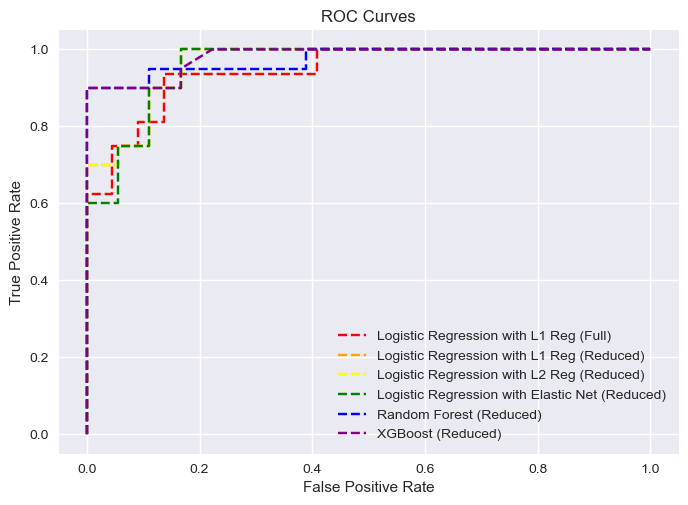

In [134]:
plt.plot(fpr1, tpr1, linestyle='--',color='red', label='Logistic Regression with L1 Reg (Full)')
plt.plot(fpr2, tpr2, linestyle='--',color='orange', label='Logistic Regression with L1 Reg (Reduced)')
plt.plot(fpr3, tpr3, linestyle='--',color='yellow', label='Logistic Regression with L2 Reg (Reduced)')
plt.plot(fpr4, tpr4, linestyle='--',color='green', label='Logistic Regression with Elastic Net (Reduced)')
plt.plot(fpr5, tpr5, linestyle='--',color='blue', label='Random Forest (Reduced)')
plt.plot(fpr6, tpr6, linestyle='--',color='purple', label='XGBoost (Reduced)')

plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best');

From the above plot, it can be seen that most of the classifiers perform similarly - all quite strong. The XGBoost classifier seems to perform the best since the area under the curve (AUC) is largest. It should also be noted that out of the 6 best performing classifiers, 5 of them were trained on the reduced dataset, reflecting the importance and predictive potential of the features that were selected by the SelectKBest algorithm.

### AUC Scores

In [145]:
full_lr_l1_auc = roc_auc_score(y_test, full_lr_l1[:,1])
red_lr_l1_auc = roc_auc_score(red_y_test, red_lr_l1[:,1])
red_lr_l2_auc = roc_auc_score(red_y_test, red_lr_l2[:,1])
red_lr_en_auc = roc_auc_score(red_y_test, red_lr_en[:,1])
red_rf_auc = roc_auc_score(red_y_test, red_rf[:,1])
red_xgb_auc = roc_auc_score(red_y_test, red_xgb[:,1])

In [147]:
print('AUC Scores:')
print('Logistic Regression with L1 Reg (Full):', full_lr_l1_auc.round(3))
print('Logistic Regression with L1 Reg (Reduced):', red_lr_l1_auc.round(3))
print('Logistic Regression with L2 Reg (Reduced):', red_lr_l2_auc.round(3))
print('Logistic Regression with Elastic Net (Reduced):', red_lr_en_auc.round(3))
print('Random Forest (Reduced):', red_rf_auc.round(3))
print('XGBoost (Reduced):', red_xgb_auc.round(3))

AUC Scores:
Logistic Regression with L1 Reg (Full): 0.946
Logistic Regression with L1 Reg (Reduced): 0.964
Logistic Regression with L2 Reg (Reduced): 0.964
Logistic Regression with Elastic Net (Reduced): 0.958
Random Forest (Reduced): 0.975
XGBoost (Reduced): 0.982
